
##  1. The following cell contains the libraries needed for calculation

In [1]:
import numpy as np
import pandas as pd

from pylife.stress.histogram import *
import pylife.stress.timesignal as ts
from pylife.stress.rainflow import *
import pylife.stress.equistress

import pylife.strength.meanstress
from pylife.strength import miner
from pylife.strength import sn_curve
from pylife.strength.miner import MinerElementar, MinerHaibach
from pylife.strength import failure_probability as fp

from pylife.materialdata.woehler.diagrams.woehler_curve_diagrams import WoehlerCurveDiagrams

import pylife.mesh.meshplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

from scipy.stats import norm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import io
from IPython.display import HTML
import base64

# mpl.style.use('seaborn')
# mpl.style.use('seaborn-notebook')
mpl.style.use('bmh')
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 2. Time series signal

1. The argument 'index' contains the name of the rows
2. The argument 'column' contains the name of the columns
3. The argument 'data' contains the data belonging to the column

 For importing data using pandas Dataframe check out the file named 'pandas.ipynb'

In [2]:


t = np.linspace(0,60,60*2048)  # Numbers between 0 and 60  divided into 60*2048 intervals 
files = ['wn','sine']          # 2048 is the frequency fo the wave data generated here


wn = pd.DataFrame(index = t, columns = ['sensor_1'], data = 120*np.random.randn(len(t))) #To create a dataset with t as the name of the rows and data as the sensor_1 column 
sine = pd.DataFrame(index = t, columns = ['sensor_1'], data = 80*np.sin(2*np.pi*50*t))

input_data = [wn,sine]         # List which contains both wn and sine dataset so the length is 2
  

    
print(len(input_data))  
wn

2


sensor_1
0.000000     9.455251
0.000488   -65.161924
0.000977   -56.510299
0.001465   113.207406
0.001953  -220.943637
...               ...
59.998047 -188.994505
59.998535 -185.022557
59.999023  235.872012
59.999512    2.883045
60.000000    2.625792

[122880 rows x 1 columns]

# 3. Resampling

Here widget function has been used to create an interactive GUI which asks user's input for resampling frequency. For examples check the file widgets.ipynb

In [3]:

    # Float text widget with minimum value of 1 and maximum value of 100000 #
f_resample = widgets.FloatText(value = 1024,min=1,max=100e3,step=1,description='Resampling frequency [Hz]',
    disabled=False,readout=True,readout_format='d')
display(f_resample)




FloatText(value=1024.0, description='Resampling frequency [Hz]', step=1.0)

The following cell resamples the data of frequency 2048 Hz to the frequency specified by user input in the above widget

In [4]:
meas_resample = []
for file_act in input_data:
    #  Function for resampling the dataset of specified frequency #
    meas_resample.append(ts.TimeSignalPrep(file_act).resample_acc(f_resample.value))

meas_resample

[             sensor_1
 0.000000     9.455251
 0.000977   -56.510440
 0.001953  -220.932759
 0.002930     9.882285
 0.003906   -11.749340
 ...               ...
 59.996094 -156.635734
 59.997070  -86.269472
 59.998047 -188.994376
 59.999023  235.868220
 60.000000    2.625792
 
 [61441 rows x 1 columns],
                sensor_1
 0.000000   0.000000e+00
 0.000977   2.416047e+01
 0.001953   4.606464e+01
 0.002930   6.366692e+01
 0.003906   7.532347e+01
 ...                 ...
 59.996094 -7.532347e+01
 59.997070 -6.366692e+01
 59.998047 -4.606464e+01
 59.999023 -2.416047e+01
 60.000000 -8.152041e-11
 
 [61441 rows x 1 columns]]

The following cell creates a widget which asks for user input on which sensor data to plot

In [5]:

print("select channel to plot")
plotChan = widgets.Dropdown(options = file_act.columns)  # Dropdown widget function #
display(plotChan)



select channel to plot


Dropdown(options=('sensor_1',), value='sensor_1')

The following cell plots the data set (signal) of the chosen channel. It utilizes matplotlib function for plotting dataset

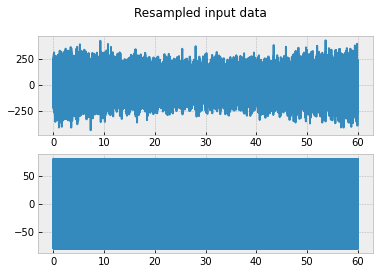

In [6]:


fig, ax = plt.subplots(len(meas_resample))  # Matplotlib function for creating plots
fig.suptitle('Resampled input data')        # For creating title name
ii = 0


#  Plots the value of index against the sensor data #
for df_act in meas_resample:    
    if len(meas_resample) == 1:
        ax.plot(df_act.index, df_act[plotChan.value])   #df_act.index will have the index values and df_act(plotchan:value) will have the sensor data
    
    #For creating more than one plot
    else:
        ax[ii].plot(df_act.index, df_act[plotChan.value]) 
    ii += 1
    plt.savefig('Resampling.png')


# 4. Fitering

Filtering the time series with a bandpass filter.

The following cell creates two Floattext widget for mentioning min and max frequency for bandpass filter

In [7]:
f_min = widgets.FloatText(value = 5,description='min frequency [Hz]',disabled=False)
f_max = widgets.FloatText(value = 100,description='max frequency [Hz]',disabled=False)
display(f_min)
display(f_max)



FloatText(value=5.0, description='min frequency [Hz]')

FloatText(value=100.0, description='max frequency [Hz]')

The following cell demonstrates the working of band pass filter for the above mentioned frequency range

In [8]:


bandpass = []                                       # Contains the bandpass filtered dataset

for df_act in meas_resample:
    
    bandpassDF = pd.DataFrame(index = df_act.index) # Takes in the index of the data set
    for col_act in df_act.columns:
                # Goes through each row of the datset and filters it #
        bandpassDF[col_act] = ts.TimeSignalPrep(df_act[col_act]).butter_bandpass(f_min.value,f_max.value,f_resample.value,5)
    bandpass.append(bandpassDF)

display(bandpass)

[            sensor_1
 0.000000   23.765668
 0.000977    5.785125
 0.001953   -4.990474
 0.002930   -4.221677
 0.003906    7.925131
 ...              ...
 59.996094 -33.698274
 59.997070 -42.203626
 59.998047 -42.065720
 59.999023 -33.165084
 60.000000 -18.749786
 
 [61441 rows x 1 columns],
             sensor_1
 0.000000   -8.334309
 0.000977   16.235768
 0.001953   38.536669
 0.002930   56.522408
 0.003906   68.551345
 ...              ...
 59.996094 -57.333292
 59.997070 -46.097898
 59.998047 -29.018913
 59.999023  -7.767889
 60.000000  15.587944
 
 [61441 rows x 1 columns]]

# 5. Running Statistics

The following cell creates widgets which asks for the type of statistics to be performed on the data set. 

In [9]:
print("select channel to for running stats")
runChan = widgets.Dropdown(options = df_act.columns)
display(runChan)
print(" Running statistics method")
method_choice = widgets.Dropdown(options = ['rms','max','min','abs'])
display(method_choice)

paraRunStats = ['window_length', 'buffer_overlap', 'limit']
values = [800,0.1,0.015]
child = [widgets.FloatText(description=name) for name in paraRunStats]
tab = widgets.Tab()
tab.children = child
for i in range(len(child)):
    tab.set_title(i, paraRunStats[i])
    tab.children[i].value = values[i]

tab

select channel to for running stats


Dropdown(options=('sensor_1',), value='sensor_1')

 Running statistics method


Dropdown(options=('rms', 'max', 'min', 'abs'), value='rms')

The function resample, butter_bandpass and running_stats_filt are functions of time signal generator.  For more information refer the file timesignal.py in the stress folder of the pylife library

The following cell performs the above mentioned statistics using the function time signal and the sub-function running_stats_filt

In [10]:
cleaned = []                        #Contains cleaned dataset after running the statistics

for df_act in bandpass:
    cleaned_df = ts.TimeSignalPrep(df_act).running_stats_filt(
                            col = runChan.value,
                            window_length = int(tab.children[0].value),
                            buffer_overlap = int(tab.children[1].value),
                            limit = tab.children[2].value,
                            method = method_choice.value)     #Performs statistics on the data set
    cleaned.append(cleaned_df)



with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cleaned)

[             sensor_1
0.000000    23.765668
0.000977     5.785125
0.001953    -4.990474
0.002930    -4.221677
0.003906     7.925131
0.004883    26.929691
0.005859    45.713106
0.006836    57.265310
0.007812    57.074243
0.008789    44.535047
0.009766    22.977173
0.010742    -1.556994
0.011719   -22.275886
0.012695   -33.675128
0.013672   -33.034758
0.014648   -20.989605
0.015625    -1.084033
0.016602    21.484646
0.017578    41.501786
0.018555    55.212849
0.019531    61.171612
0.020508    60.219579
0.021484    54.680576
0.022461    47.155045
0.023438    39.452345
0.024414    32.119265
0.025391    24.724641
0.026367    16.684939
0.027344     8.156155
0.028320     0.498429
0.029297    -3.960102
0.030273    -2.784724
0.031250     5.465352
0.032227    20.402040
0.033203    39.613644
0.034180    59.187693
0.035156    74.729882
0.036133    82.497082
0.037109    80.281698
0.038086    67.835141
0.039062    46.808393
0.040039    20.328892
0.041016    -7.621860
0.041992   -32.900396
0.042969 

In [11]:
print("select channel to plot")
plotChan = widgets.Dropdown(options = file_act.columns)
display(plotChan)

select channel to plot


Dropdown(options=('sensor_1',), value='sensor_1')

The following cell plots the above cleaned input data using the time signal function

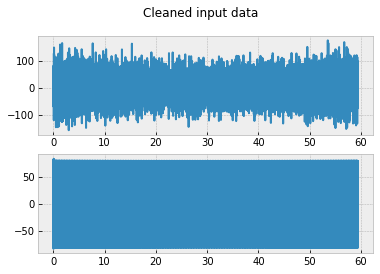

In [12]:
fig, ax = plt.subplots(len(meas_resample))
fig.suptitle('Cleaned input data')

for i, df_act in enumerate(cleaned):
    if len(meas_resample) == 1:
        ax.plot(df_act.index, df_act[plotChan.value])
    else:
        ax[i].plot(df_act.index, df_act[plotChan.value])
    plt.savefig('Running_statistics.png')


# 6. Rainflow Counting algorithm

The following cell creates two widgets
1. A Dropdown widget for asking which sensor data to plot 
2. A slider widget for asking number of bins

In [13]:
rfcChan = widgets.Dropdown(options = df_act.columns)
display(rfcChan)


binwidget = widgets.IntSlider(value = 64, min=1, max=1024, step=1,description='Bins:')
display(binwidget)

Dropdown(options=('sensor_1',), value='sensor_1')

IntSlider(value=64, description='Bins:', max=1024, min=1)

The following cell implements the rainflow counting algorithm on the dataset specified above(The sensor data chosen)
1. RainflowCounterFKM() processes the sample chunk and returns the from and to position of the closed hystersis loop on the sample 
2. get_rainflow_matrix_frame takes in no of bins as input and returns a dataframe which contains bi-directional histogram values assigned to appropriate bin indices


In [14]:
rainflow = []
rfc_box = []


for df_act in cleaned:
    rfc = RainflowCounterFKM().process(df_act[rfcChan.value].values)
    rfm = rfc.get_rainflow_matrix_frame(binwidget.value)
    rainflow.append(rfm)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(rainflow)

[                                                                                          0
from                                       to                                              
(-147.1628104226376, -142.29395074367142]  (-155.13879037673456, -150.08917169971056]   0.0
                                           (-150.08917169971056, -145.03955302268656]   0.0
                                           (-145.03955302268656, -139.98993434566256]   0.0
                                           (-139.98993434566256, -134.94031566863856]   0.0
                                           (-134.94031566863856, -129.89069699161456]   0.0
                                           (-129.89069699161456, -124.84107831459056]   0.0
                                           (-124.84107831459056, -119.79145963756656]   0.0
                                           (-119.79145963756656, -114.74184096054256]   0.0
                                           (-114.74184096054256, -109.692222283

[[  0. -inf -inf ... -inf -inf -inf]
 [-inf   0. -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 ...
 [-inf -inf -inf ...   0. -inf   0.]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf   0.]]


<ipython-input-15-404c067c0d29>:20: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(counts))
<ipython-input-15-404c067c0d29>:24: RuntimeWarning: divide by zero encountered in log10
  pl = ax.imshow(np.log10(counts), extent=[froms.min(), froms.max(), tos.min(), tos.max()])


[[     -inf 0.             -inf ...      -inf      -inf      -inf]
 [3.1693805 0.             -inf ...      -inf      -inf      -inf]
 [0.             -inf      -inf ...      -inf      -inf      -inf]
 ...
 [     -inf      -inf      -inf ...      -inf      -inf      -inf]
 [     -inf      -inf      -inf ...      -inf      -inf 0.       ]
 [     -inf      -inf      -inf ... 0.        3.1708482      -inf]]


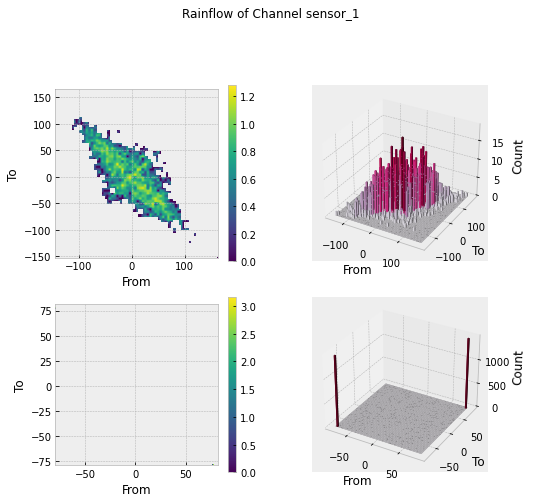

In [15]:
colormap = cm.ScalarMappable()
cmap = cm.get_cmap('PuRd')

fig = plt.figure(figsize = (8,11))                     # Plot of size 8*11
fig.suptitle('Rainflow of Channel ' + rfcChan.value) 


for i, rf_act in enumerate(rainflow):
    
    
    # 2D Plot 
    
    ax = fig.add_subplot(3,2,2*(i+1)-1)                # Subplot -- Grid parameters (3*2 grid, subplot index) 
    froms = rf_act.index.get_level_values('from').mid  # Accesses 'from' indices and gets mid value
    tos = rf_act.index.get_level_values('to').mid      # Accesses 'to' indices and gets mid value
    
    # Gets the shape of the dataset(histogram) and reshapes the values of the dataset into a 2D array #
    # Flip function - To plot increasing order (from bottom of the plot)
    counts = np.flipud((rf_act.values.reshape(rf_act.index.levshape).T))#.ravel()
    print(np.log10(counts))
    
    ax.set_xlabel('From')
    ax.set_ylabel('To')
    pl = ax.imshow(np.log10(counts), extent=[froms.min(), froms.max(), tos.min(), tos.max()])
    fig.colorbar(pl)
  
    
    
    # 3D Plot
    
    ax = fig.add_subplot(3,2,2*(i+1), projection='3d')          # For 3D subplots
    bottom = np.zeros_like(counts.ravel())
    
    # Gets the ranges of all the from and to indices(length) and finds out the minimum one #
    width = rf_act.index.get_level_values('from').length.min()
    depth = rf_act.index.get_level_values('to').length.min()    # For setting width and depth(minimum value)nof the bar graph 
    
    
    max_height = np.max(counts.ravel())   # get range of colorbars
    min_height = np.min(counts.ravel())
    rgba = [cmap((k-min_height)/max_height) for k in counts.ravel()]
    
    
    ax.set_xlabel('From')
    ax.set_ylabel('To')
    ax.set_zlabel('Count')
    pl3= ax.bar3d(froms.ravel(), tos.ravel(), bottom, width, depth, counts.ravel(), shade=True, color=rgba, zsort='average')
    plt.savefig('Rainflow.png')

# 7. Meanstress transformation

Creates widget for asking user input of the required slope values and the stress ratio (R_Goal)

In [16]:
meanstress_para = ['M', 'M2', 'R_Goal']
values = [0.3,0.2,-1]
child = [widgets.FloatText(description=name) for name in meanstress_para]
tab_mean = widgets.Tab()
tab_mean.children = child
for i in range(len(child)):
    tab_mean.set_title(i, meanstress_para[i])
    tab_mean.children[i].value = values[i]

tab_mean

The following cell does means stress transformation on the stress cycle and transforms to an equivalent stress cycle with zero mean stress

In [17]:
transformed = []
for rf_act in rainflow:
    transformed.append(rf_act.meanstress_hist.FKM_goodman(pd.Series({'M': tab_mean.children[0].value,
                                                                     'M2': tab_mean.children[1].value})
                                                          , R_goal = tab_mean.children[2].value))
    
transformed

[                                         frequency
 range                                             
 (0.0, 5.038769836126726]                       232
 (5.038769836126726, 10.077539672253453]        195
 (10.077539672253453, 15.11630950838018]        179
 (15.11630950838018, 20.155079344506905]        197
 (20.155079344506905, 25.19384918063363]        172
 ...                                            ...
 (292.24865049535015, 297.2874203314769]          1
 (297.2874203314769, 302.32619016760356]          1
 (302.32619016760356, 307.3649600037303]          1
 (307.3649600037303, 312.403729839857]            1
 (312.403729839857, 317.44249967598375]           2
 
 [63 rows x 1 columns],
                                           frequency
 range                                              
 (0.0, 2.5766306356403064]                         0
 (2.5766306356403064, 5.153261271280613]           0
 (5.153261271280613, 7.729891906920919]            0
 (7.729891906920919, 10.306522542

In [18]:
child = [widgets.FloatText(description=name) for name in files]
tab_repeat = widgets.Tab()
tab_repeat.children = child
for i in range(len(child)):
    tab_repeat.set_title(i, files[i])
    tab_repeat.children[i].value = int(50/(i+1))

tab_repeat


In [19]:

for ii in range(len(files)):
    transformed[ii] = transformed[ii]*tab_repeat.children[ii].value
    
range_only_total = combine_hist(transformed,method = "sum")
display(range_only_total)   


frequency
range                                              
(0.0, 4.960039057437246]                    11600.0
(4.960039057437246, 9.920078114874492]       9750.0
(9.920078114874492, 14.880117172311738]      8950.0
(14.880117172311738, 19.840156229748985]     9850.0
(19.840156229748985, 24.80019528718623]      8600.0
...                                             ...
(292.6423043887975, 297.6023434462348]         50.0
(297.6023434462348, 302.56238250367204]        50.0
(302.56238250367204, 307.52242156110924]       50.0
(307.52242156110924, 312.4824606185465]        50.0
(312.4824606185465, 317.44249967598375]       100.0

[64 rows x 1 columns]

The following cell plots the data for whole dataset and for the datas from different sensors (wn, sine) in the following manner  

                  I) Amplitude vs Cycles(Frequency)
                 II) Amplitude vs Cumulative sum of the cycles

array([5.0e+01, 7.4e+04, 5.0e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00])

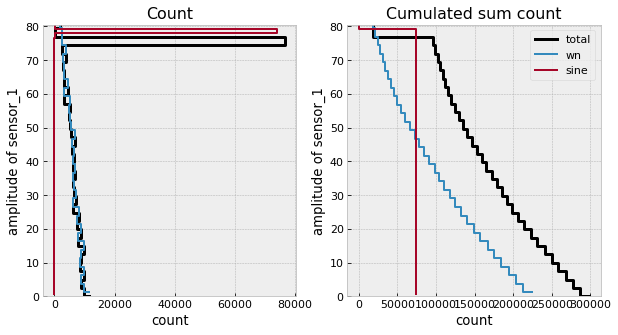

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))
amplitude = range_only_total.index.get_level_values('range').left.values[::-1]/2
cycles = range_only_total.values[::-1].ravel()


ax[0].step(cycles,amplitude,c = "black",linewidth = 3, label = "total")
ax[1].step(np.cumsum(cycles),amplitude,c = "black",linewidth = 3, label = "total")
ii=0
for range_only in transformed:
    amplitude = range_only.index.get_level_values('range').mid.values[::-1]/2
    cycles = range_only.values[::-1].ravel()
    ax[0].step(cycles,amplitude,label = files [ii])
    ax[1].step(np.cumsum(cycles),amplitude,label = files [ii])
    ii += 1
ax[0].set_title('Count')
ax[1].set_title('Cumulated sum count')
ax[1].legend()

for ai in ax:
    ai.xaxis.grid(True)
    ai.set_xlabel('count')
    ai.set_ylabel('amplitude of ' + rfcChan.value)
    ai.set_ylim((0,max(amplitude)))
    plt.savefig('Meanstress.png')
    
amplitude
cycles

# 8. Material Parameters

The following cell creates a pandas data set for the material parameters to be utilized using pd.series function

In [21]:
mat = pd.Series(index = ['k_1', 'ND_50', 'SD_50', '1/TN', '1/TS'],
                data = [8, 1.5e+06, 1.5e+02, 12, 1.1])
display(mat)

k_1            8.0
ND_50    1500000.0
SD_50        150.0
1/TN          12.0
1/TS           1.1
dtype: float64

# 9. Damage calculation

In [22]:
SNmethod = widgets.Dropdown(options = ['Miner Elementar','Miner Haibach','Miner original'])
display(SNmethod)

Dropdown(options=('Miner Elementar', 'Miner Haibach', 'Miner original'), value='Miner Elementar')

In [23]:
damage_calc = sn_curve.FiniteLifeCurve(**mat.drop(['1/TN','1/TS']))
damage = damage_calc.calc_damage(range_only_total,method = 'original')

print("\033[5m  Total Damage of channel %s: %.2e  \033[0m" % (rfcChan.value,damage.sum()))

2021-03-26 19:08:37,727 - pylife.strength.sn_curve - WARNING - Using all cycles



  Total Damage of channel sensor_1: 3.40e-01  


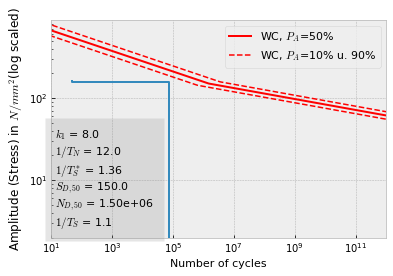

In [24]:
SRI = mat['SD_50']*(mat['ND_50']**(1/mat['k_1']))
# Plotting
diagdata = WoehlerCurveDiagrams(mat, fatigue_data = None, analyzer = None,
                                y_min=2, y_max=SRI, x_min=1e1, x_max=1e12, ax = None)
diagdata.plot_fitted_curve( k_2=15)
plt.step(np.cumsum(cycles),2*amplitude)
plt.savefig('Damage_SN.png')

# 10. Local Stress Approach

# FE based propability calculation

The following cell reads a hdf file which contains dataset of each node like stress tensor components, coordinates etc., And then it computes vonmises stress of each element using equistress.mises function.

In [25]:

filename = 'plate_with_hole.h5'

stress = pd.read_hdf(filename, 'node_data')
stress['S13'] = np.zeros_like(stress['S11'])
stress['S23'] = np.zeros_like(stress['S11'])
display(stress)


""" Equivalent stress """
s_vm = stress.groupby('element_id').mean().equistress.mises().rename(columns={'mises': 'sigma_a'})   # Function for finding vonmises stress
s_vm = 2*s_vm/s_vm.max()
display(s_vm)

""" Scale with """
ampl_fe = pd.DataFrame(data = amplitude, columns = ["ampl"] ,index =cycles)
display(ampl_fe)
s_vm_scaled = pd.DataFrame(data = ampl_fe.values*s_vm.transpose().values,index = ampl_fe.index,columns = s_vm.index)
display(s_vm_scaled)


E11       E22  E33       E12  PE11  PE22  PE33  PE12  \
node_id element_id                                                              
1734    1           0.000119 -0.000006  0.0 -0.000169   0.0   0.0   0.0   0.0   
1582    1           0.000133 -0.000035  0.0 -0.000133   0.0   0.0   0.0   0.0   
1596    1           0.000219 -0.000042  0.0 -0.000221   0.0   0.0   0.0   0.0   
4923    1           0.000126 -0.000020  0.0 -0.000151   0.0   0.0   0.0   0.0   
4924    1           0.000176 -0.000038  0.0 -0.000177   0.0   0.0   0.0   0.0   
...                      ...       ...  ...       ...   ...   ...   ...   ...   
3812    4770        0.000170 -0.000040  0.0 -0.000182   0.0   0.0   0.0   0.0   
12418   4770        0.000152 -0.000031  0.0 -0.000177   0.0   0.0   0.0   0.0   
14446   4770        0.000158 -0.000032  0.0 -0.000171   0.0   0.0   0.0   0.0   
14614   4770        0.000168 -0.000038  0.0 -0.000171   0.0   0.0   0.0   0.0   
14534   4770        0.000157 -0.000035  0.0 -0.000181   0.0   0.0   0.0   0.0   

                          S11       S22  S33        S12          x         y  \
node_id element_id                                                             
1734    1           27.080811  6.927080  0.0 -13.687358  14.897208  5.269875   
1582    1           28.319006  1.178649  0.0 -10.732705  14.555333  5.355806   
1596    1           47.701195  5.512213  0.0 -17.866833  14.630658  4.908741   
4923    1           27.699907  4.052865  0.0 -12.210032  14.726271  5.312840   
4924    1           38.010101  3.345431  0.0 -14.299768  14.592996  5.132274   
...                       ...       ...  ...        ...        ...       ...   
3812    4770        36.527439  2.470588  0.0 -14.706686 -13.189782 -5.691876   
12418   4770        32.868889  3.320898  0.0 -14.260107 -13.560289 -5.278386   
14446   4770        34.291058  3.642457  0.0 -13.836027 -13.673285 -5.569107   
14614   4770        36.063541  2.828889  0.0 -13.774759 -13.389065 -5.709927   
14534   4770        33.804211  2.829817  0.0 -14.580153 -13.276068 -5.419206   

                      z  S13  S23  
node_id element_id                 
1734    1           0.0  0.0  0.0  
1582    1           0.0  0.0  0.0  
1596    1           0.0  0.0  0.0  
4923    1           0.0  0.0  0.0  
4924    1           0.0  0.0  0.0  
...                 ...  ...  ...  
3812    4770        0.0  0.0  0.0  
12418   4770        0.0  0.0  0.0  
14446   4770        0.0  0.0  0.0  
14614   4770        0.0  0.0  0.0  
14534   4770        0.0  0.0  0.0  

[37884 rows x 17 columns]

sigma_a
element_id          
1           0.390050
2           0.354357
3           0.619928
4           0.298421
5           0.422100
...              ...
4766        0.446868
4767        0.382246
4768        0.356033
4769        0.415434
4770        0.394457

[4770 rows x 1 columns]

ampl
50.0     80.519707
74000.0  79.231392
50.0     77.943077
0.0      76.654761
0.0      75.366446
...            ...
0.0       5.797419
0.0       4.509104
0.0       3.220788
0.0       1.932473
0.0       0.644158

[63 rows x 1 columns]

element_id       1          2          3          4          5          6     \
50.0        31.406709  28.532743  49.916402  24.028753  33.987345  57.059782   
74000.0     30.904202  28.076219  49.117739  23.644293  33.443548  56.146826   
50.0        30.401695  27.619695  48.319077  23.259833  32.899750  55.233869   
0.0         29.899187  27.163171  47.520414  22.875373  32.355953  54.320913   
0.0         29.396680  26.706647  46.721752  22.490913  31.812155  53.407956   
...               ...        ...        ...        ...        ...        ...   
0.0          2.261283   2.054357   3.593981   1.730070   2.447089   4.108304   
0.0          1.758776   1.597834   2.795318   1.345610   1.903291   3.195348   
0.0          1.256268   1.141310   1.996656   0.961150   1.359494   2.282391   
0.0          0.753761   0.684786   1.197994   0.576690   0.815696   1.369435   
0.0          0.251254   0.228262   0.399331   0.192230   0.271899   0.456478   

element_id       7          8          9          10    ...       4761  \
50.0        11.880762  50.965962  24.556584  50.046306  ...  20.741842   
74000.0     11.690670  50.150507  24.163679  49.245565  ...  20.409973   
50.0        11.500577  49.335052  23.770774  48.444824  ...  20.078103   
0.0         11.310485  48.519596  23.377868  47.644083  ...  19.746234   
0.0         11.120393  47.704141  22.984963  46.843342  ...  19.414364   
...               ...        ...        ...        ...  ...        ...   
0.0          0.855415   3.669549   1.768074   3.603334  ...   1.493413   
0.0          0.665323   2.854094   1.375169   2.802593  ...   1.161543   
0.0          0.475230   2.038638   0.982263   2.001852  ...   0.829674   
0.0          0.285138   1.223183   0.589358   1.201111  ...   0.497804   
0.0          0.095046   0.407728   0.196453   0.400370  ...   0.165935   

element_id       4762       4763       4764       4765       4766       4767  \
50.0        35.520845  22.371388  24.751949  24.485636  35.981674  30.778331   
74000.0     34.952512  22.013446  24.355918  24.093866  35.405967  30.285878   
50.0        34.384178  21.655504  23.959886  23.702096  34.830260  29.793424   
0.0         33.815845  21.297561  23.563855  23.310326  34.254553  29.300971   
0.0         33.247511  20.939619  23.167824  22.918555  33.678846  28.808518   
...               ...        ...        ...        ...        ...        ...   
0.0          2.557501   1.610740   1.782140   1.762966   2.590680   2.216040   
0.0          1.989167   1.252798   1.386109   1.371196   2.014974   1.723587   
0.0          1.420834   0.894856   0.990078   0.979425   1.439267   1.231133   
0.0          0.852500   0.536913   0.594047   0.587655   0.863560   0.738680   
0.0          0.284167   0.178971   0.198016   0.195885   0.287853   0.246227   

element_id       4768       4769       4770  
50.0        28.667691  33.450610  31.761560  
74000.0     28.209008  32.915401  31.253375  
50.0        27.750325  32.380191  30.745190  
0.0         27.291642  31.844981  30.237005  
0.0         26.832959  31.309771  29.728820  
...               ...        ...        ...  
0.0          2.064074   2.408444   2.286832  
0.0          1.605391   1.873234   1.778647  
0.0          1.146708   1.338024   1.270462  
0.0          0.688025   0.802815   0.762277  
0.0          0.229342   0.267605   0.254092  

[63 rows x 4770 columns]

## Damage Calculation

The following cell calculates the number of cycles to falure for a given stress amplitude

In [26]:
N = damage_calc.calc_N(s_vm_scaled,ignore_limits = True)
print(N)

2021-03-26 19:08:38,600 - pylife.strength.sn_curve - WARNING - Using all cycles



element_id          1             2             3             4     \
50.0        4.061083e+11  8.751312e+11  9.974133e+09  3.459166e+12   
74000.0     4.620416e+11  9.956630e+11  1.134787e+10  3.935597e+12   
50.0        5.267918e+11  1.135195e+12  1.293815e+10  4.487130e+12   
0.0         6.019304e+11  1.297112e+12  1.478358e+10  5.127148e+12   
0.0         6.893425e+11  1.485479e+12  1.693045e+10  5.871711e+12   
...                  ...           ...           ...           ...   
0.0         5.623178e+20  1.211750e+21  1.381068e+19  4.789735e+21   
0.0         4.198920e+21  9.048341e+21  1.031267e+20  3.576574e+22   
0.0         6.196720e+22  1.335344e+23  1.521932e+21  5.278269e+23   
0.0         3.689367e+24  7.950295e+24  9.061190e+22  3.142545e+25   
0.0         2.420594e+28  5.216188e+28  5.945047e+26  2.061824e+29   

element_id          5             6             7             8     \
50.0        2.159153e+11  3.421216e+09  9.684273e+14  8.444608e+09   
74000.0     2.45653

In [27]:
d_mesh_cycle =  1/(N.div(N.index.values, axis = 'index'))
print(d_mesh_cycle)

element_id          1             2             3             4     \
50.0        1.231199e-10  5.713429e-11  5.012967e-09  1.445435e-11   
74000.0     1.601587e-07  7.432233e-08  6.521047e-06  1.880274e-08   
50.0        9.491416e-11  4.404531e-11  3.864539e-09  1.114298e-11   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                  ...           ...           ...           ...   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

element_id          5             6             7             8     \
50.0        2.315723e-10  1.461469e-08  5.163010e-14  5.920938e-09   
74000.0     3.01237

In [28]:
display(d_mesh_cycle.max())

element_id
1       1.601587e-07
2       7.432233e-08
3       6.521047e-06
4       1.880274e-08
5       3.012376e-07
            ...     
4766    4.753594e-07
4767    1.362485e-07
4768    7.718145e-08
4769    2.652183e-07
4770    1.752208e-07
Length: 4770, dtype: float64

In [29]:
d_mesh = d_mesh_cycle.sum()
d_mesh


element_id
1       1.603768e-07
2       7.442351e-08
3       6.529925e-06
4       1.882833e-08
5       3.016476e-07
            ...     
4766    4.760065e-07
4767    1.364340e-07
4768    7.728652e-08
4769    2.655794e-07
4770    1.754594e-07
Length: 4770, dtype: float64

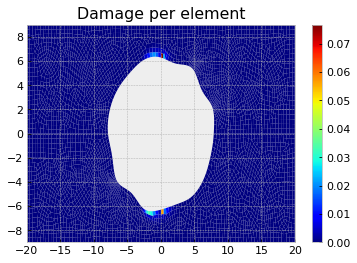

<Figure size 432x288 with 0 Axes>

In [30]:
fig, ax = plt.subplots()
stress.join(pd.DataFrame(data = d_mesh,columns = ['d'])).meshplot.plot(ax, 'd', cmap='jet')
plt.title("Damage per element")
plt.show()
plt.savefig('Damage_plate.png')


# 11. Wöhler analyzing tool

## Initialization

In [31]:
import numpy as np
import pandas as pd
from os import path
import sys, os
import json

import pylife.materialdata.woehler as woehler
import pylife.utils.diagrams.probability_data as probdiagram
from pylife.materialdata.woehler.controls.data_file_display import DataFileDisplay
from pylife.materialdata.woehler.controls.woehler_curve_analyzer_options import  WoehlerCurveAnalyzerOptions
from pylife.materialdata.woehler.controls.woehler_curve_data_plotter import  WoehlerCurveDataPlotter
from pylife.materialdata.woehler.controls.whole_woehler_curve_plotter import  WholeWoehlerCurvePlotter
from pylife.materialdata.woehler.diagrams.woehler_curve_diagrams import WoehlerCurveDiagrams


In [32]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import warnings
import pdb

##  Data import

Data is made up of two columns:
* The first column is made up of the load values
* The second column is made up of the load-cycle values

In [33]:
file_name = 'woehler-test-data.csv'


## Transforming data in csv to python arrays

In [34]:
data = pd.read_csv(file_name, sep='\t')
data.columns=['load', 'cycles']
data

load    cycles
0   284.39285   1369000
1   284.39285  10000000
2   284.39285  10000000
3   284.39285  10000000
4   284.39285  10000000
5   294.19950    411000
6   294.19950  10000000
7   294.19950  10000000
8   294.19950  10000000
9   294.19950   2295000
10  304.00615    570000
11  304.00615   7868000
12  304.00615   1745000
13  304.00615  10000000
14  304.00615    502000
15  313.81280    727000
16  313.81280    231000
17  313.81280   1826000
18  313.81280   1943000
19  313.81280    413000
20  323.61945   1842000
21  323.61945   2200000
22  323.61945    166000
23  323.61945    312000
24  323.61945    981000
25  333.42610    397000
26  333.42610    532000
27  333.42610    326000
28  333.42610    146000
29  333.42610    763000

In [35]:
ld_cyc_lim = None
data = woehler.determine_fractures(data, ld_cyc_lim)
data

load    cycles  fracture
0   284.39285   1369000      True
1   284.39285  10000000     False
2   284.39285  10000000     False
3   284.39285  10000000     False
4   284.39285  10000000     False
5   294.19950    411000      True
6   294.19950  10000000     False
7   294.19950  10000000     False
8   294.19950  10000000     False
9   294.19950   2295000      True
10  304.00615    570000      True
11  304.00615   7868000      True
12  304.00615   1745000      True
13  304.00615  10000000     False
14  304.00615    502000      True
15  313.81280    727000      True
16  313.81280    231000      True
17  313.81280   1826000      True
18  313.81280   1943000      True
19  313.81280    413000      True
20  323.61945   1842000      True
21  323.61945   2200000      True
22  323.61945    166000      True
23  323.61945    312000      True
24  323.61945    981000      True
25  333.42610    397000      True
26  333.42610    532000      True
27  333.42610    326000      True
28  333.42610    146000      True
29  333.42610    763000      True

In [36]:
fatigue_data = data.fatigue_data
display(fatigue_data)

In [37]:
woehler_curve_analyzer_options = WoehlerCurveAnalyzerOptions(fatigue_data)

RadioButtons(description='Select method', options=('Maximum likelihood 2 params', 'Maximum likelihood 5 params…

k_1      8.626165e+00
ND_50    1.326971e+06
SD_50    2.952540e+02
1/TN     1.205947e+01
1/TS     1.106812e+00
dtype: float64
BIC: 54.92940437923815


RadioButtons(description='Plot Type', options=('Only initial data', 'Slope', 'Pearl chain', 'Deviation in load…

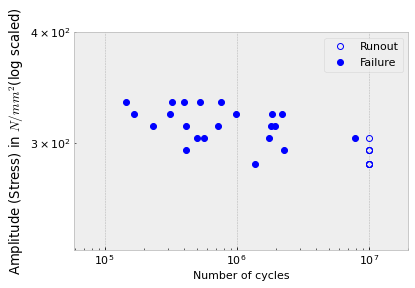

In [38]:
woehler_curve = woehler_curve_analyzer_options.woehler_curve
analyzer      = woehler_curve_analyzer_options.analyzer()
woehler_curve_data_plotter = WoehlerCurveDataPlotter(woehler_curve, fatigue_data, analyzer)

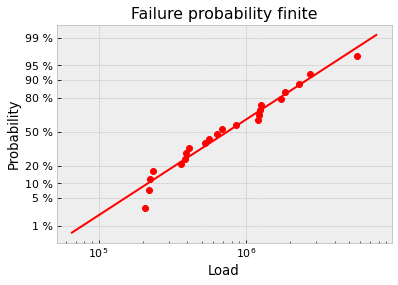

In [39]:
probdiag_finite = probdiagram.ProbabilityDataDiagram(analyzer.pearl_chain_estimator(),
                                                    occurrences_name='Load',
                                                    title='Failure probability finite')
probdiag_finite.plot()
if isinstance(analyzer, woehler.analyzers.probit.Probit):
    probdiag_infinite = probdiagram.ProbabilityDataDiagram(analyzer.pearl_chain_estimator(),
                                                        occurrences_name='Load',
                                                        title='Failure probability inffinite')
    probdiag_infinite.plot()

# Hotspot calculation demo

In [40]:
import numpy as np
import pylife
import pandas as pd
import scipy.stats as stats
import pylife.stress.equistress
import pylife.strength.meanstress
import pylife.mesh.meshplot
import pylife.mesh.hotspot
import matplotlib.pyplot as plt

In [41]:
filename = 'plate_with_hole.h5'
fe_res = pd.read_hdf(filename, 'node_data')
fe_res['S13'] = np.zeros_like(fe_res['S11'])
fe_res['S23'] = np.zeros_like(fe_res['S11'])
display(fe_res)

E11       E22  E33       E12  PE11  PE22  PE33  PE12  \
node_id element_id                                                              
1734    1           0.000119 -0.000006  0.0 -0.000169   0.0   0.0   0.0   0.0   
1582    1           0.000133 -0.000035  0.0 -0.000133   0.0   0.0   0.0   0.0   
1596    1           0.000219 -0.000042  0.0 -0.000221   0.0   0.0   0.0   0.0   
4923    1           0.000126 -0.000020  0.0 -0.000151   0.0   0.0   0.0   0.0   
4924    1           0.000176 -0.000038  0.0 -0.000177   0.0   0.0   0.0   0.0   
...                      ...       ...  ...       ...   ...   ...   ...   ...   
3812    4770        0.000170 -0.000040  0.0 -0.000182   0.0   0.0   0.0   0.0   
12418   4770        0.000152 -0.000031  0.0 -0.000177   0.0   0.0   0.0   0.0   
14446   4770        0.000158 -0.000032  0.0 -0.000171   0.0   0.0   0.0   0.0   
14614   4770        0.000168 -0.000038  0.0 -0.000171   0.0   0.0   0.0   0.0   
14534   4770        0.000157 -0.000035  0.0 -0.000181   0.0   0.0   0.0   0.0   

                          S11       S22  S33        S12          x         y  \
node_id element_id                                                             
1734    1           27.080811  6.927080  0.0 -13.687358  14.897208  5.269875   
1582    1           28.319006  1.178649  0.0 -10.732705  14.555333  5.355806   
1596    1           47.701195  5.512213  0.0 -17.866833  14.630658  4.908741   
4923    1           27.699907  4.052865  0.0 -12.210032  14.726271  5.312840   
4924    1           38.010101  3.345431  0.0 -14.299768  14.592996  5.132274   
...                       ...       ...  ...        ...        ...       ...   
3812    4770        36.527439  2.470588  0.0 -14.706686 -13.189782 -5.691876   
12418   4770        32.868889  3.320898  0.0 -14.260107 -13.560289 -5.278386   
14446   4770        34.291058  3.642457  0.0 -13.836027 -13.673285 -5.569107   
14614   4770        36.063541  2.828889  0.0 -13.774759 -13.389065 -5.709927   
14534   4770        33.804211  2.829817  0.0 -14.580153 -13.276068 -5.419206   

                      z  S13  S23  
node_id element_id                 
1734    1           0.0  0.0  0.0  
1582    1           0.0  0.0  0.0  
1596    1           0.0  0.0  0.0  
4923    1           0.0  0.0  0.0  
4924    1           0.0  0.0  0.0  
...                 ...  ...  ...  
3812    4770        0.0  0.0  0.0  
12418   4770        0.0  0.0  0.0  
14446   4770        0.0  0.0  0.0  
14614   4770        0.0  0.0  0.0  
14534   4770        0.0  0.0  0.0  

[37884 rows x 17 columns]

In [42]:
fe_res["vM"] = pylife.stress.equistress.mises(fe_res["S11"],fe_res["S22"],fe_res["S33"],fe_res["S12"],fe_res["S13"],fe_res["S23"])
display(fe_res["vM"].sort_values(ascending = False))

node_id  element_id
5        456           287.099222
9        2852          270.115389
6433     456           260.993366
11217    2852          243.603037
119      456           236.079927
                          ...    
491      3933            1.218400
8021     1437            0.874036
6470     470             0.819183
306      2538            0.472104
         2525            0.436058
Name: vM, Length: 37884, dtype: float64

In [43]:
display(fe_res)

E11       E22  E33       E12  PE11  PE22  PE33  PE12  \
node_id element_id                                                              
1734    1           0.000119 -0.000006  0.0 -0.000169   0.0   0.0   0.0   0.0   
1582    1           0.000133 -0.000035  0.0 -0.000133   0.0   0.0   0.0   0.0   
1596    1           0.000219 -0.000042  0.0 -0.000221   0.0   0.0   0.0   0.0   
4923    1           0.000126 -0.000020  0.0 -0.000151   0.0   0.0   0.0   0.0   
4924    1           0.000176 -0.000038  0.0 -0.000177   0.0   0.0   0.0   0.0   
...                      ...       ...  ...       ...   ...   ...   ...   ...   
3812    4770        0.000170 -0.000040  0.0 -0.000182   0.0   0.0   0.0   0.0   
12418   4770        0.000152 -0.000031  0.0 -0.000177   0.0   0.0   0.0   0.0   
14446   4770        0.000158 -0.000032  0.0 -0.000171   0.0   0.0   0.0   0.0   
14614   4770        0.000168 -0.000038  0.0 -0.000171   0.0   0.0   0.0   0.0   
14534   4770        0.000157 -0.000035  0.0 -0.000181   0.0   0.0   0.0   0.0   

                          S11       S22  S33        S12          x         y  \
node_id element_id                                                             
1734    1           27.080811  6.927080  0.0 -13.687358  14.897208  5.269875   
1582    1           28.319006  1.178649  0.0 -10.732705  14.555333  5.355806   
1596    1           47.701195  5.512213  0.0 -17.866833  14.630658  4.908741   
4923    1           27.699907  4.052865  0.0 -12.210032  14.726271  5.312840   
4924    1           38.010101  3.345431  0.0 -14.299768  14.592996  5.132274   
...                       ...       ...  ...        ...        ...       ...   
3812    4770        36.527439  2.470588  0.0 -14.706686 -13.189782 -5.691876   
12418   4770        32.868889  3.320898  0.0 -14.260107 -13.560289 -5.278386   
14446   4770        34.291058  3.642457  0.0 -13.836027 -13.673285 -5.569107   
14614   4770        36.063541  2.828889  0.0 -13.774759 -13.389065 -5.709927   
14534   4770        33.804211  2.829817  0.0 -14.580153 -13.276068 -5.419206   

                      z  S13  S23         vM  
node_id element_id                            
1734    1           0.0  0.0  0.0  33.996987  
1582    1           0.0  0.0  0.0  33.399850  
1596    1           0.0  0.0  0.0  54.777007  
4923    1           0.0  0.0  0.0  33.446991  
4924    1           0.0  0.0  0.0  44.070962  
...                 ...  ...  ...        ...  
3812    4770        0.0  0.0  0.0  43.577209  
12418   4770        0.0  0.0  0.0  39.903508  
14446   4770        0.0  0.0  0.0  40.478974  
14614   4770        0.0  0.0  0.0  42.140169  
14534   4770        0.0  0.0  0.0  41.143837  

[37884 rows x 18 columns]

In [44]:
threshold = .5 # factor of the maximum local value
fe_res['hotspot'] = fe_res.hotspot.calc("vM", threshold)
display(fe_res[['x', 'y', 'z', 'vM', 'hotspot']])

x         y    z         vM  hotspot
node_id element_id                                              
1734    1           14.897208  5.269875  0.0  33.996987        0
1582    1           14.555333  5.355806  0.0  33.399850        0
1596    1           14.630658  4.908741  0.0  54.777007        0
4923    1           14.726271  5.312840  0.0  33.446991        0
4924    1           14.592996  5.132274  0.0  44.070962        0
...                       ...       ...  ...        ...      ...
3812    4770       -13.189782 -5.691876  0.0  43.577209        0
12418   4770       -13.560289 -5.278386  0.0  39.903508        0
14446   4770       -13.673285 -5.569107  0.0  40.478974        0
14614   4770       -13.389065 -5.709927  0.0  42.140169        0
14534   4770       -13.276068 -5.419206  0.0  41.143837        0

[37884 rows x 5 columns]

In [45]:
display(fe_res["hotspot"].sort_values(ascending = False))

node_id  element_id
3062     2453          4
13021    3768          3
3904     3762          3
3918     3967          3
4017     3767          3
                      ..
10299    3145          0
10281    3145          0
10305    3145          0
3333     3145          0
1734     1             0
Name: hotspot, Length: 37884, dtype: int64

In [46]:
fe_res['hotspot'].max()

4

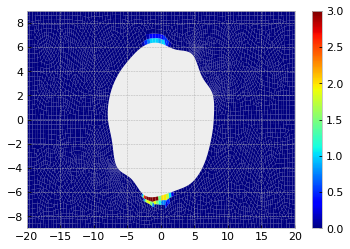

In [47]:
fig, ax = plt.subplots()
fe_res.meshplot.plot(ax, 'hotspot', cmap='jet')
plt.show()